# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц можно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [2]:
def get_w_sigma(X, t, alpha, beta, XTX=None, XTt=None):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    
    # YOUR CODE GOES HERE
    if XTX is None:
        XTX = X.T @ X
        XTt = X.T @ t       
    idx = np.where(np.isfinite(alpha))[0]
    sigma = np.zeros((d,d), dtype=np.float64)
    sigma[np.ix_(idx, idx)] = np.linalg.inv(beta * XTX[np.ix_(idx, idx)] + np.diag(alpha[idx]))
    w = beta * sigma @ XTt
    return w, sigma


def update_alpha_beta(X, t, alpha, beta, XTX=None, XTt=None):
    """Update the hyperperemeters to increase evidence"""

    # YOUR CODE GOES HERE
    weightBound = 10 ** (-9)
    alphaBound = 10 ** (15)
    if XTX is None:
        XTX = X.T @ X
        XTt = X.T @ t
    n, d = X.shape
    w, sigma = get_w_sigma(X, t, alpha, beta, XTX, XTt)
    gamma = np.zeros(d, dtype=np.float64)
    alpha_new = np.ones(d, dtype=np.float64) * np.inf
    w_new = np.zeros(d, dtype=np.float64)
    idx = np.where((np.abs(w) >= weightBound) & (np.abs(alpha) <= alphaBound))[0]
    w_new[idx] = w[idx]
    w = w_new
    gamma[idx] = 1 - alpha[idx] * sigma[idx, idx]
    alpha_new[idx] = gamma[idx] / (w[idx] ** 2)
    z = t - X @ w
    beta_new = (n - gamma.sum()) / (z.T @ z)
    
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000, alpha=None, beta=None):
    """Train the Relevance Vector Regression model"""

    # YOUR CODE GOES HERE
    XTX = X.T @ X
    XTt = X.T @ t
    n, d = X.shape
    if (alpha is None) or (beta is None):
        alpha = np.ones(d)
        beta = 1    
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta, XTX, XTt)
        if np.all(alpha == np.inf):
            break
        
    w, sigma = get_w_sigma(X, t, alpha, beta, XTX, XTt)
        
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

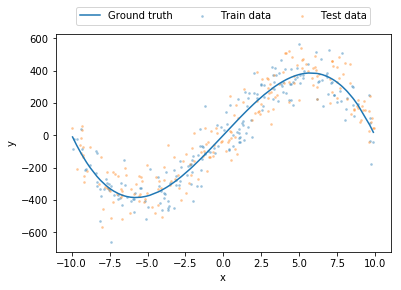

In [3]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [4]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [5]:
alpha_rvr

array([             inf,   9.93831796e-05,              inf,
         9.61886323e-01,              inf,              inf,
                    inf,              inf,              inf,
                    inf,              inf,              inf,
                    inf,              inf,              inf,
                    inf,              inf,              inf,
                    inf,              inf,              inf])

In [6]:
w_rvr

array([   0.        ,  100.26572402,    0.        ,   -1.01849279,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,    0.        ])

In [7]:
beta_rvr

0.00010773558337532083

In [8]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [9]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

D:\ProgramFiles\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\ProgramFiles\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Relevance Vector Regression
Features remaining: 2 / 21
Train error: 9189.30784477
Test error:  9530.95637989
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 8090.96629035
Test error:  12256.7842488
--------------------------------------------------
Lasso Regression
Features remaining: 19 / 21
Train error: 8941.22847976
Test error:  10237.8405027


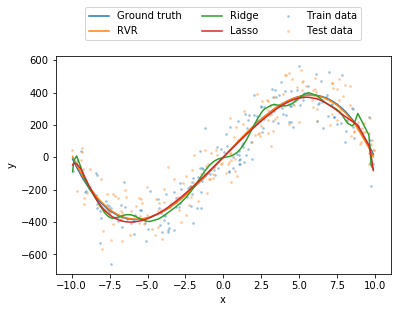

In [10]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

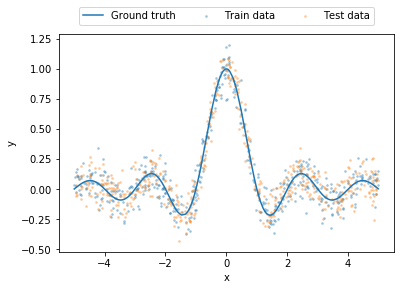

In [11]:
# Генерация данных
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

points_train = np.array(points_train).reshape(-1,1)
points_test = np.array(points_test).reshape(-1,1)

# RBF-transform
X_train = rbf_kernel(points_train, points_train)
X_test = rbf_kernel(points_test, points_train)

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [12]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, max_iter=30000)

In [13]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

D:\ProgramFiles\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\ProgramFiles\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [14]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 11 / 500
Train error: 0.00944546665494
Test error:  0.00930529012435
--------------------------------------------------
Lasso Regression
Objects remaining: 148 / 500
Train error: 0.00945624997543
Test error:  0.00934661882521
--------------------------------------------------
Support Vector Regression
Objects remaining: 163 / 500
Train error: 0.00947339517678
Test error:  0.00948180161155


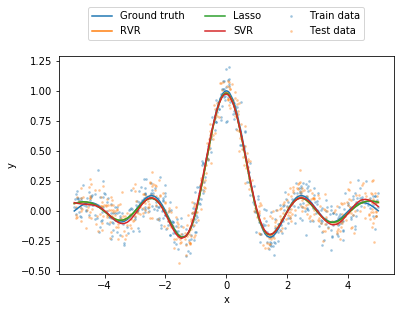

In [15]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')
plt.plot(points_train, X_train.dot(w_lasso), label='Lasso')
plt.plot(points_train, svr.predict(points_train.reshape(-1, 1)), label='SVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

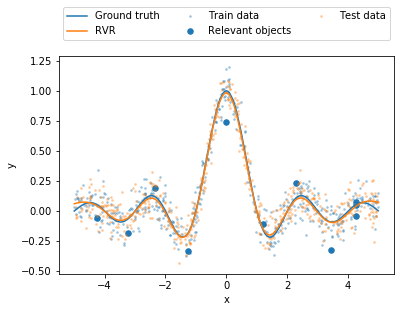

In [16]:
relevant = alpha_rvr[1:] < 1e8
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

### Сначала о полученных результатах
Видно, что в обоих экспериментах если ничего не менять в настройках Lasso и SVR, то RVR показывает лучшие результаты на тестовой выборке, что можно интерпретировать как меньшую переобученность RVR. Но! Во-первых, на моем компьютере с последней версией sklearn при обучении Lasso появляются ворнинги с сообщением о невозможности сойтись при дефолдных параметрах (точность и число итераций). Также в SVR есть управляемый параметр C, отвечающий за регуляризацию. Возможно, при более тонкой настройке параметров, мы сможем уменьшить прееобучение и, возможно, в первом эксперименте у Lasso и SVR есть шансы догнать и обогнать RVR. Во втором эксперименте RVR лучше как и на тестовой выборке, так и на обучающей.

### Несколько замечаний и наблюдений
* RVR оказался численно неустойчив. Без искуственного обрезания слишком больших и малых значений метод может получать кардинально разные результаты на двух сосдених итерациях.
* При $\alpha_i=inf$ или $w_i=0$ теоретически $\gamma_i$ не определена. Но в презентации предлагают положить 0. Как это объяснить?
* В двух из 10 случаев RVR в первом эксперименте отбирает не те признаки.

Посмотрим на количество отбираемых признаков в зависимости от шага итерации

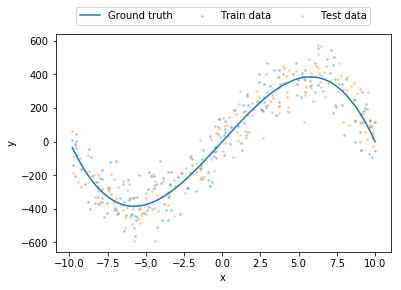

In [19]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

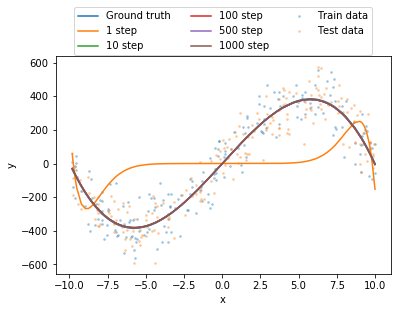

In [21]:
n_alpha = []
alpha = np.ones(d)
w_list = []
beta = 1
for i in range(1000):
    w, sigma, alpha, beta = fit_rvr(X_train, t_train, max_iter=1, alpha = alpha, beta=beta)
    n_alpha.append(np.sum(alpha[1:] < 1e8))
    w_list.append(w)

plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_list[0]), label='1 step')
plt.plot(X_train[:, 1], X_train.dot(w_list[9]), label='10 step')
plt.plot(X_train[:, 1], X_train.dot(w_list[99]), label='100 step')
plt.plot(X_train[:, 1], X_train.dot(w_list[499]), label='500 step')
plt.plot(X_train[:, 1], X_train.dot(w_list[999]), label='1000 step')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

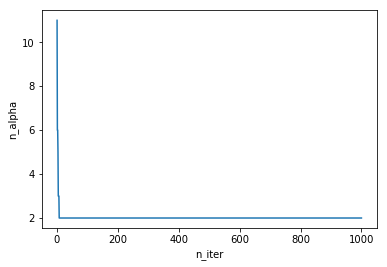

In [22]:
plt.plot(np.arange(1000) + 1, n_alpha)

plt.axes().set_xlabel('n_iter')
plt.axes().set_ylabel('n_alpha')
plt.show()

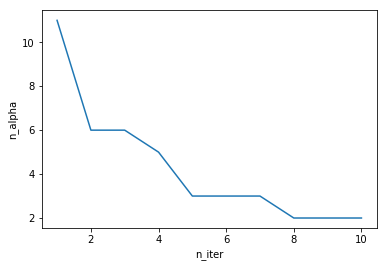

In [23]:
plt.plot(np.arange(10) + 1, n_alpha[:10])

plt.axes().set_xlabel('n_iter')
plt.axes().set_ylabel('n_alpha')
plt.show()

Видно, что в первой задаче RVR сошелся всего за 8 шагов.

Посмотрим, что будет во втором эксперименте

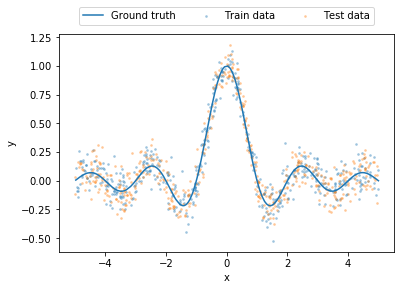

In [24]:
# Генерация данных
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

points_train = np.array(points_train).reshape(-1,1)
points_test = np.array(points_test).reshape(-1,1)

# RBF-transform
X_train = rbf_kernel(points_train, points_train)
X_test = rbf_kernel(points_test, points_train)

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

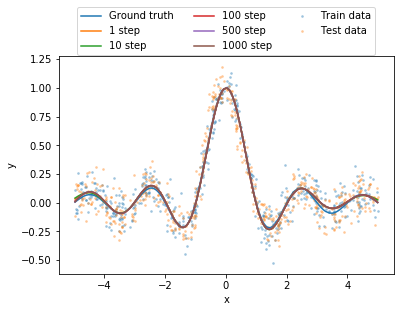

In [28]:
n_alpha = []
alpha = np.ones(d)
w_list = []
beta = 1
for i in range(1000):
    w, sigma, alpha, beta = fit_rvr(X_train, t_train, max_iter=1, alpha = alpha, beta=beta)
    n_alpha.append(np.sum(alpha[1:] < 1e8))
    w_list.append(w)

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_list[0]), label='1 step')
plt.plot(points_train, X_train.dot(w_list[9]), label='10 step')
plt.plot(points_train, X_train.dot(w_list[99]), label='100 step')
plt.plot(points_train, X_train.dot(w_list[499]), label='500 step')
plt.plot(points_train, X_train.dot(w_list[999]), label='1000 step')


plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

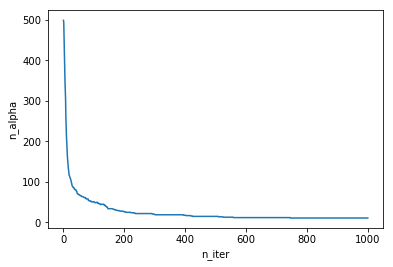

In [29]:
plt.plot(np.arange(1000) + 1, n_alpha)

plt.axes().set_xlabel('n_iter')
plt.axes().set_ylabel('n_alpha')
plt.show()

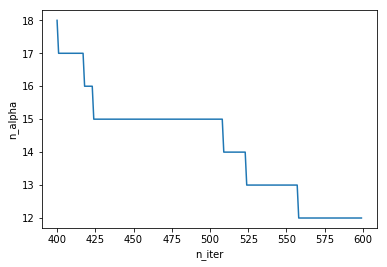

In [30]:
plt.plot(np.arange(200) + 400, n_alpha[400:600])

plt.axes().set_xlabel('n_iter')
plt.axes().set_ylabel('n_alpha')
plt.show()

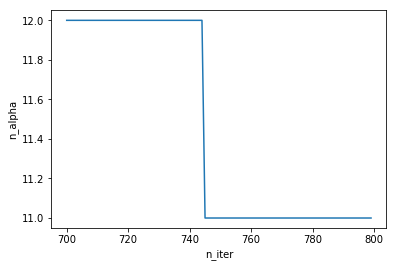

In [31]:
plt.plot(np.arange(100) + 700, n_alpha[700:800])

plt.axes().set_xlabel('n_iter')
plt.axes().set_ylabel('n_alpha')
plt.show()

В принципе уже на 400-ом шаге можно говорить о насыщении. Но последнее изменение количества релевантных веткоров происходит примерно на 745 шаге.

### Некоторые выводы:
1. RVR действительно хорошо отбирает признаки/опорные объекты, причем лучше, чем Lasso без настройки. Интересно было бы сравнить с Elastic Net или с SVR с предварительным отбором признаков.
2. Без хитрой оптимизации работает медленно. Наверно, стоит поверить лектору по поводу 50-ти кратном росте времени обучения по сравнению с линейной регрессией.
3. Насколько я понял, RVR с RBF признаками имеет такие же преимущества, что и SVR: нужно хранить лишь малую часть выборки, легко делать предикты, можно использовать другие ядерные функции.